In [22]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ClusterEnsembles as CE
from sklearn.metrics import normalized_mutual_info_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet

## HCAS-SQI (Hierachical Cluster and Select with Single Quality Index)

Step 1. Computing pair-wise diversity measure matrix in which each element of matrix is diversity measure between two base clustering members. 

Step 2. Using a hierarchical clustering algorithm on the diversity measure matrix, all clusering members are partitioned as a dendrogram.

Step 3. Partition the dendrogram from layer L, where L =(1, 100). 

Step 4. Choosing the one ensemble member from each group with highest quality:
        Strategy a: 
        Strategy b: 

Step 5. Calculate Dominant ratio and NMI using ground truth label and full ensemble consensus solution

##### Set path for loading dataset from your local computer (Ignore if all your files are on same place)

In [23]:
dataset_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES Data/Project 3 IR+Raman Data/'
output_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES ML results/Project 3 IR+Raman Results/'

### Step 1. Compute pair-wise similarity measure matrix
The similarity between two clustering solutions is defined as:

S = NMI(Pi,Pj)

In [24]:
def get_matrix(df):
    index = df.index[0:300]
    df_Similarity_matrix = pd.DataFrame(0,index=index, columns=index)
    for i in range(300):
        for j in range(300):
            df_Similarity_matrix.iloc[i,j] = normalized_mutual_info_score(df.iloc[i,:],df.iloc[j,:])
    return df_Similarity_matrix

### Step 2-4. Using a clustering algorithm on the diversity measure matrix, all clusering are partitioned as a dendrogram.
* Partition all clustering solutions into different clusters according to their pair-wise similarity matrix

In [77]:
def get_HCAS_n(df,method):
    X = df.values
    print("Linkage method = ", method)
    Z = linkage(X,method=method)
    
    df_tmp = df_BC_quality_merge.copy()
    
    for n_cluster in range(5,155,5):
        print("Partition BC members into", n_cluster, "clusters")
        df_tmp[str(method)+"_k_"+str(n_cluster)]=fcluster(Z,t=n_cluster,criterion='maxclust').tolist()
        print("Saving BC member partition results to df_HCAS_tmp dataframe")
    print("Done")
    
    return df_tmp

##### Evaluate Performance using Dominant ratio and NMI

In [26]:
def Dominant_ratio(subset, non_subset, consensus_function):
    
    Y1 = CE.cluster_ensembles(subset.values, solver = consensus_function, verbose=False, nclass = 16, random_state=42)
    Y2 = CE.cluster_ensembles(non_subset.values, solver = consensus_function, verbose=False, nclass = 16, random_state=42)
    
    NMI1 = normalized_mutual_info_score(Y,Y1)
    NMI2 = normalized_mutual_info_score(Y,Y2)
    
    return NMI1, NMI1/NMI2

##### Load the dataframe of the dataset that you are treating. Only change the filename.
* df_result_merge: The BC library with cluster label of data points
    - The first 300 rows are the BC members
    - The bottom few lines are the consensus clustering solution using the full ensemble
* df_BC_quality_merge: The dataframe for collecting 

In [243]:
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"
run_i="run_20"


df_result_merge = pd.read_csv(output_path+filename+" BC library "+run_i+".csv", index_col="Unnamed: 0")
Y_HBGF_EN = df_result_merge.loc["HBGF_EN"]
Y_CSPA_EN = df_result_merge.loc["CSPA_EN"]
print("Y_CSPA_EN and Y_HBGF_EN are the full ensemble consensus solution")

df_BC_quality_merge = pd.read_csv(output_path+filename+" BC library quality indices "+run_i+".csv",index_col="BC_run")

df = pd.read_csv(dataset_path+filename+".csv")
print("Y is the ground truth class label")
Y=df.Class

NMI_CSPA_EN = normalized_mutual_info_score(Y,Y_CSPA_EN)
NMI_HBGF_EN = normalized_mutual_info_score(Y,Y_HBGF_EN)

NMI_Average = df_BC_quality_merge['NMI_Y'].mean()

Y_CSPA_EN and Y_HBGF_EN are the full ensemble consensus solution
Y is the ground truth class label


##### Two selection strategy
###### Sorted:
* Asking for n_cluster = 150
* Keep the highest quality ensemble member from each group
* Sort in descending order of quality
* Select J ensemble members for the final subset

###### Nonsorted:
* Asking for n_cluster = (5, 155,5)
* For each n_cluster, keep the highest quality ensemble member from each group for the final subset


In [244]:
consensus_functions = ["cspa", "hbgf"]

# Quality indices
Qs = ["SNMI","Silhouette"]

# Linkage methods
HCAS_methods = ['single', 'complete', 'average', 'weighted', 'ward']
df_tmp = df_result_merge.iloc[0:300]

df_S = get_matrix(df_result_merge)

#### Initialize a dataframe for collecting results

In [245]:
J = range(5,155,5)
df_HCAS_result = pd.DataFrame(columns=J)

### Choose a hierarchical clustering linkage method, then repeat the calculation using two different quality indices

In [246]:
Method=HCAS_methods[4]
print("df_HCAS is the merged dataframe of ensemble member group and quality indices data")
print(Method)
df_HCAS = get_HCAS_n(df_S,Method)

df_HCAS is the merged dataframe of ensemble member group and quality indices data
ward
Linkage method =  ward
Partition BC members into 5 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 10 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 15 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 20 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 25 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 30 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 35 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 40 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition BC members into 45 clusters
Saving BC member partition results to df_HCAS_tmp dataframe
Partition

In [247]:
for Qi in Qs:
    print("Quality index used in ensemble selection:", Qi)

    for consensus_function in consensus_functions:
        print("Compute consensus solution of selected subset using ", consensus_function, "consensus function")
        EN_tmp = consensus_function.upper()
    
        print("Create subset and nonsubset using non-sorted strategy a and compute subset consensus performance")
        NMI, Ratio = [], []
        for J in range(5,155,5):
            partition = Method+"_k_"+str(J)
            subset_idx = df_HCAS.sort_values(by = [partition, Qi], ascending = [True, False]).drop_duplicates(subset=[partition],keep='first').index
            subset_J=df_tmp.loc[subset_idx]
            nonsubset_J=df_tmp.drop(subset_idx,axis=0)
    
            NMI_J, Dominant_ratio_J = Dominant_ratio(subset_J, nonsubset_J, consensus_function)
            NMI.append(NMI_J)
            Ratio.append(Dominant_ratio_J)
        df_HCAS_result.loc[EN_tmp+"_"+str(Qi)+"_NMI"] = NMI
        df_HCAS_result.loc[EN_tmp+"_"+str(Qi)+"_Dominant_ratio"] = Ratio
        print("Done")
    
        print("Create subset and nonsubset using sorted strategy b and compute subset consensus performance")
        partition = Method+"_k_"+str(J)
        df_sorted = df_HCAS.sort_values(by = [partition, Qi], ascending = [True, False]).drop_duplicates(subset=[partition],keep='first').sort_values(by=[Qi],ascending=False)
    
        NMI, Ratio = [], []
        for J in range(5,155,5):
            subset_idx=df_sorted.iloc[0:J].index
            subset_J=df_tmp.loc[subset_idx]
            nonsubset_J=df_tmp.drop(subset_idx,axis=0)
        
            NMI_J, Dominant_ratio_J = Dominant_ratio(subset_J, nonsubset_J, consensus_function)
            NMI.append(NMI_J)
            Ratio.append(Dominant_ratio_J)
        df_HCAS_result.loc[EN_tmp+"_Sorted_"+str(Qi)+"_NMI"] = NMI
        df_HCAS_result.loc[EN_tmp+"_Sorted_"+str(Qi)+"_Dominant_ratio"] = Ratio
        print("Done")
    
print("*****Done*****")

Quality index used in ensemble selection: SNMI
Compute consensus solution of selected subset using  cspa consensus function
Create subset and nonsubset using non-sorted strategy a and compute subset consensus performance
Done
Create subset and nonsubset using sorted strategy b and compute subset consensus performance
Done
Compute consensus solution of selected subset using  hbgf consensus function
Create subset and nonsubset using non-sorted strategy a and compute subset consensus performance
Done
Create subset and nonsubset using sorted strategy b and compute subset consensus performance
Done
Quality index used in ensemble selection: Silhouette
Compute consensus solution of selected subset using  cspa consensus function
Create subset and nonsubset using non-sorted strategy a and compute subset consensus performance
Done
Create subset and nonsubset using sorted strategy b and compute subset consensus performance
Done
Compute consensus solution of selected subset using  hbgf consensus f

In [248]:
df_HCAS_result.shape

(16, 30)

In [249]:
df_HCAS_result.to_csv(output_path+filename+" HCAS-SQI comparison_"+ Method+"_"+run_i+".csv",index=True)

### Plots

In [156]:
def get_final_average(n, Method):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    Average_NMI_CSPA_EN = 0
    Average_NMI_HBGF_EN = 0
    Average_NMI_Y = 0
    
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        Average_NMI_CSPA_EN += normalized_mutual_info_score(Y,Y_CSPA_EN)

        Y_HBGF_EN = result_i.loc["HBGF_EN"]
        Average_NMI_HBGF_EN += normalized_mutual_info_score(Y,Y_HBGF_EN)

        
        quality_i = pd.read_csv(output_path+filename+" BC library quality indices run_"+str(i+1)+".csv",index_col="BC_run")
        NMI_Y = quality_i['NMI_Y'].mean()
        Average_NMI_Y += quality_i['NMI_Y'].mean()

        
        run_i = pd.read_csv(output_path+filename+" HCAS-SQI comparison_"+ Method+"_run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    df_concat=pd.concat(runs)
    unique_index = df_concat.index.unique()
    
    average = []
    for index in unique_index:
        average.append(df_concat.loc[index].mean(numeric_only=True))
        
    df_final_average = pd.DataFrame(average,index=unique_index)
    
    return df_final_average, Average_NMI_Y/n, Average_NMI_CSPA_EN/n, Average_NMI_HBGF_EN/n

In [250]:
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"

Method = 'ward'
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(20, Method)

run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge


In [251]:
NMI_Average

0.6076374012141722

In [252]:
NMI_CSPA_EN

0.6607164486962143

In [253]:
NMI_HBGF_EN

0.6904820544427916

#### CSPA

CSPA consensus function, NMI


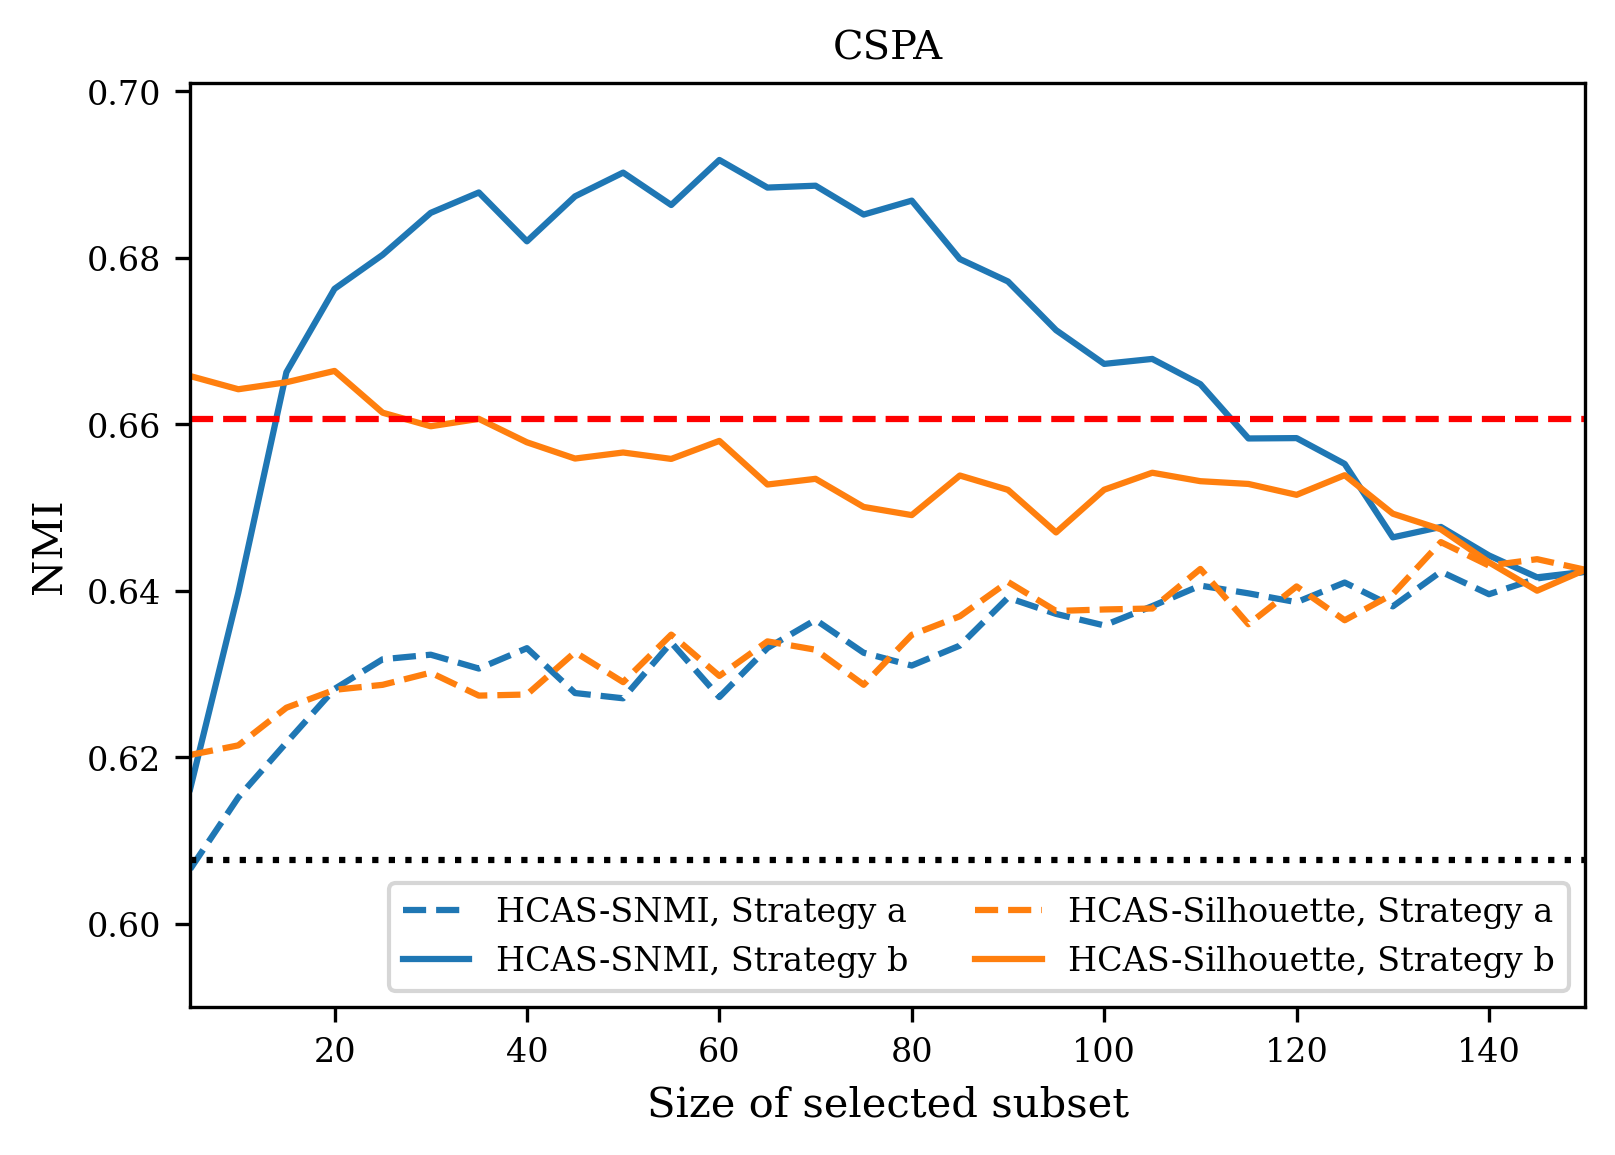

In [263]:
print("CSPA consensus function, NMI")
num=range(5,155,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.title("CSPA")
plt.xlim(5,150,5)
plt.ylim(0.59,0.701,0.01)
plt.plot(num,df_final_average.loc["CSPA_SNMI_NMI"], label = "HCAS-SNMI, Strategy a", linestyle="--",color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Sorted_SNMI_NMI"],label = "HCAS-SNMI, Strategy b",  color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Silhouette_NMI"], label = "HCAS-Silhouette, Strategy a", linestyle="--",color="#ff7f0e")
plt.plot(num,df_final_average.loc["CSPA_Sorted_Silhouette_NMI"], label = "HCAS-Silhouette, Strategy b", color="#ff7f0e")

plt.axhline(y=NMI_CSPA_EN, color="r", linestyle="--")
plt.axhline(y=NMI_Average, color="black", linestyle=":")

legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" HCAS-SQI "+Method+" using CSPA comparison NMI.png", bbox_inches="tight", dpi = 300)

CSPA consensus function, Dominant ratio


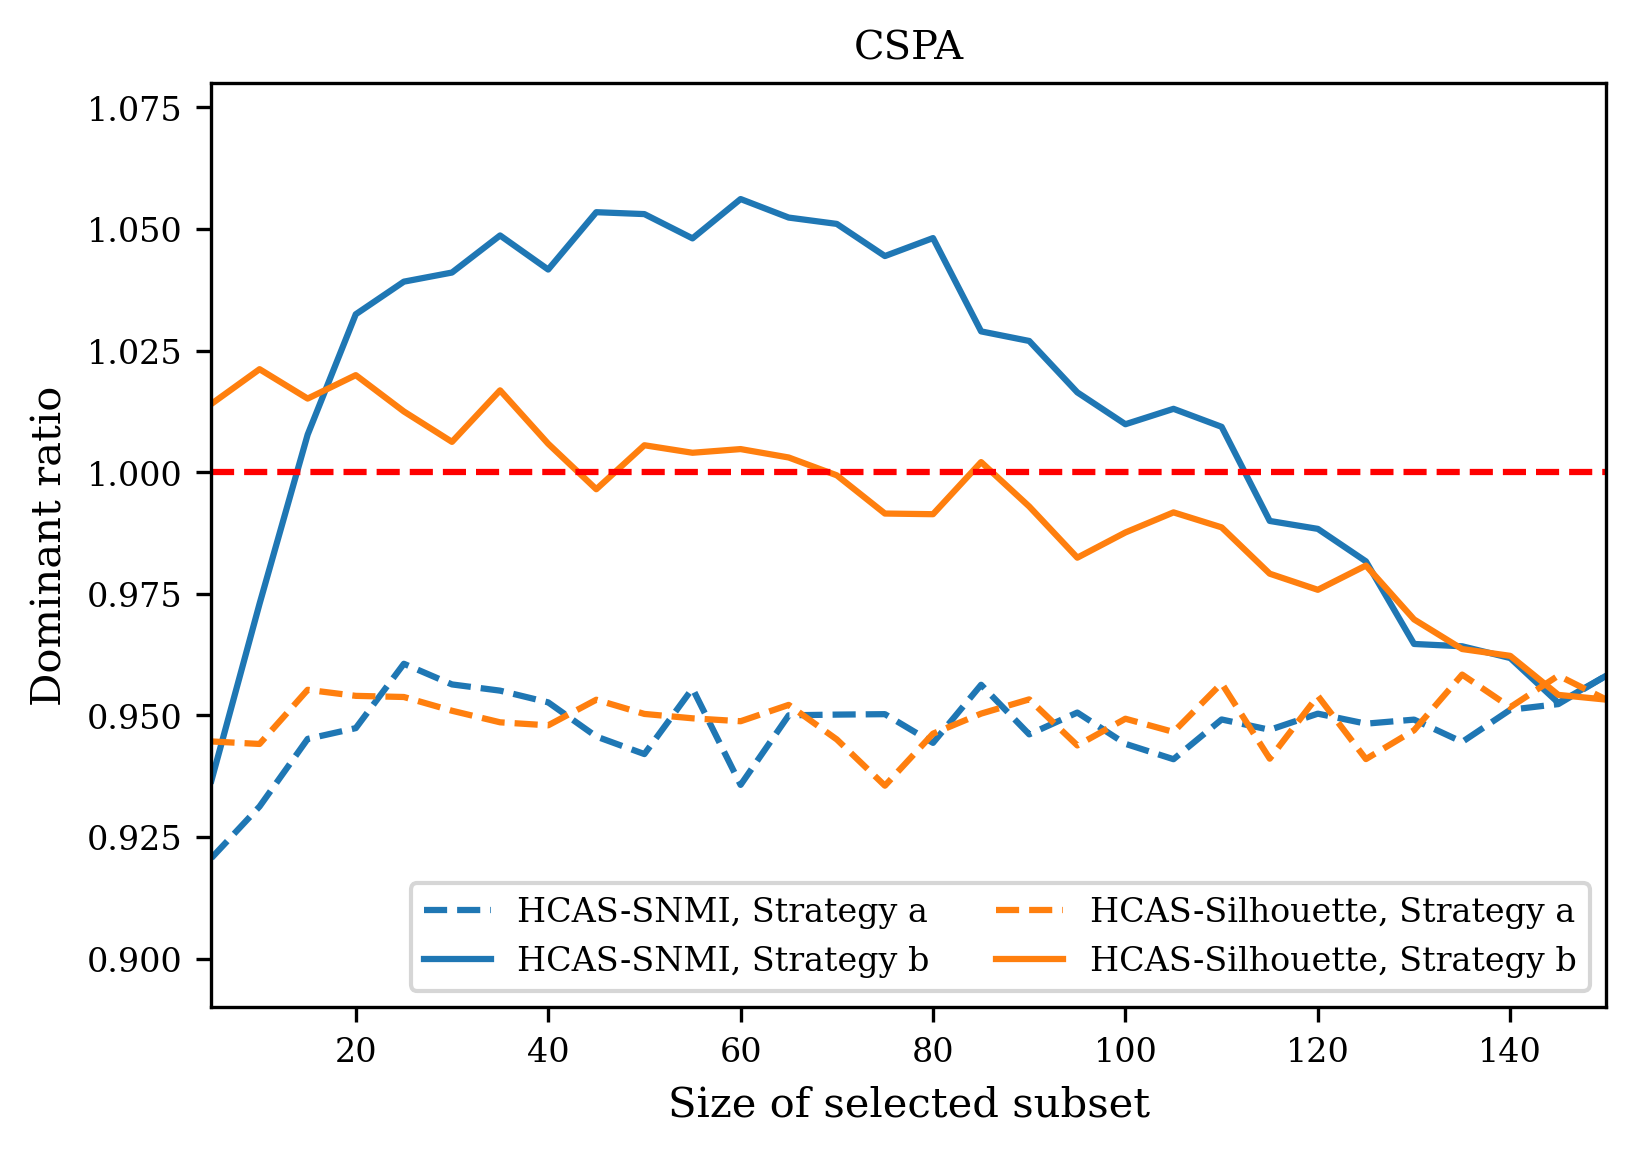

In [261]:
print("CSPA consensus function, Dominant ratio")
num=range(5,155,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.title("CSPA")
plt.xlim(5,150,5)
plt.ylim(0.89,1.08,0.1)
plt.plot(num,df_final_average.loc["CSPA_SNMI_Dominant_ratio"], label = "HCAS-SNMI, Strategy a", linestyle="--", color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Sorted_SNMI_Dominant_ratio"], label = "HCAS-SNMI, Strategy b", color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Silhouette_Dominant_ratio"], label = "HCAS-Silhouette, Strategy a",linestyle="--", color="#ff7f0e")
plt.plot(num,df_final_average.loc["CSPA_Sorted_Silhouette_Dominant_ratio"], label = "HCAS-Silhouette, Strategy b", color="#ff7f0e")

plt.axhline(y=1.00, color="r", linestyle="--")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" HCAS-SQI "+Method+" using CSPA comparison Dominant ratio.png", bbox_inches="tight", dpi = 300)

#### HBGF

HBGF consensus function, NMI


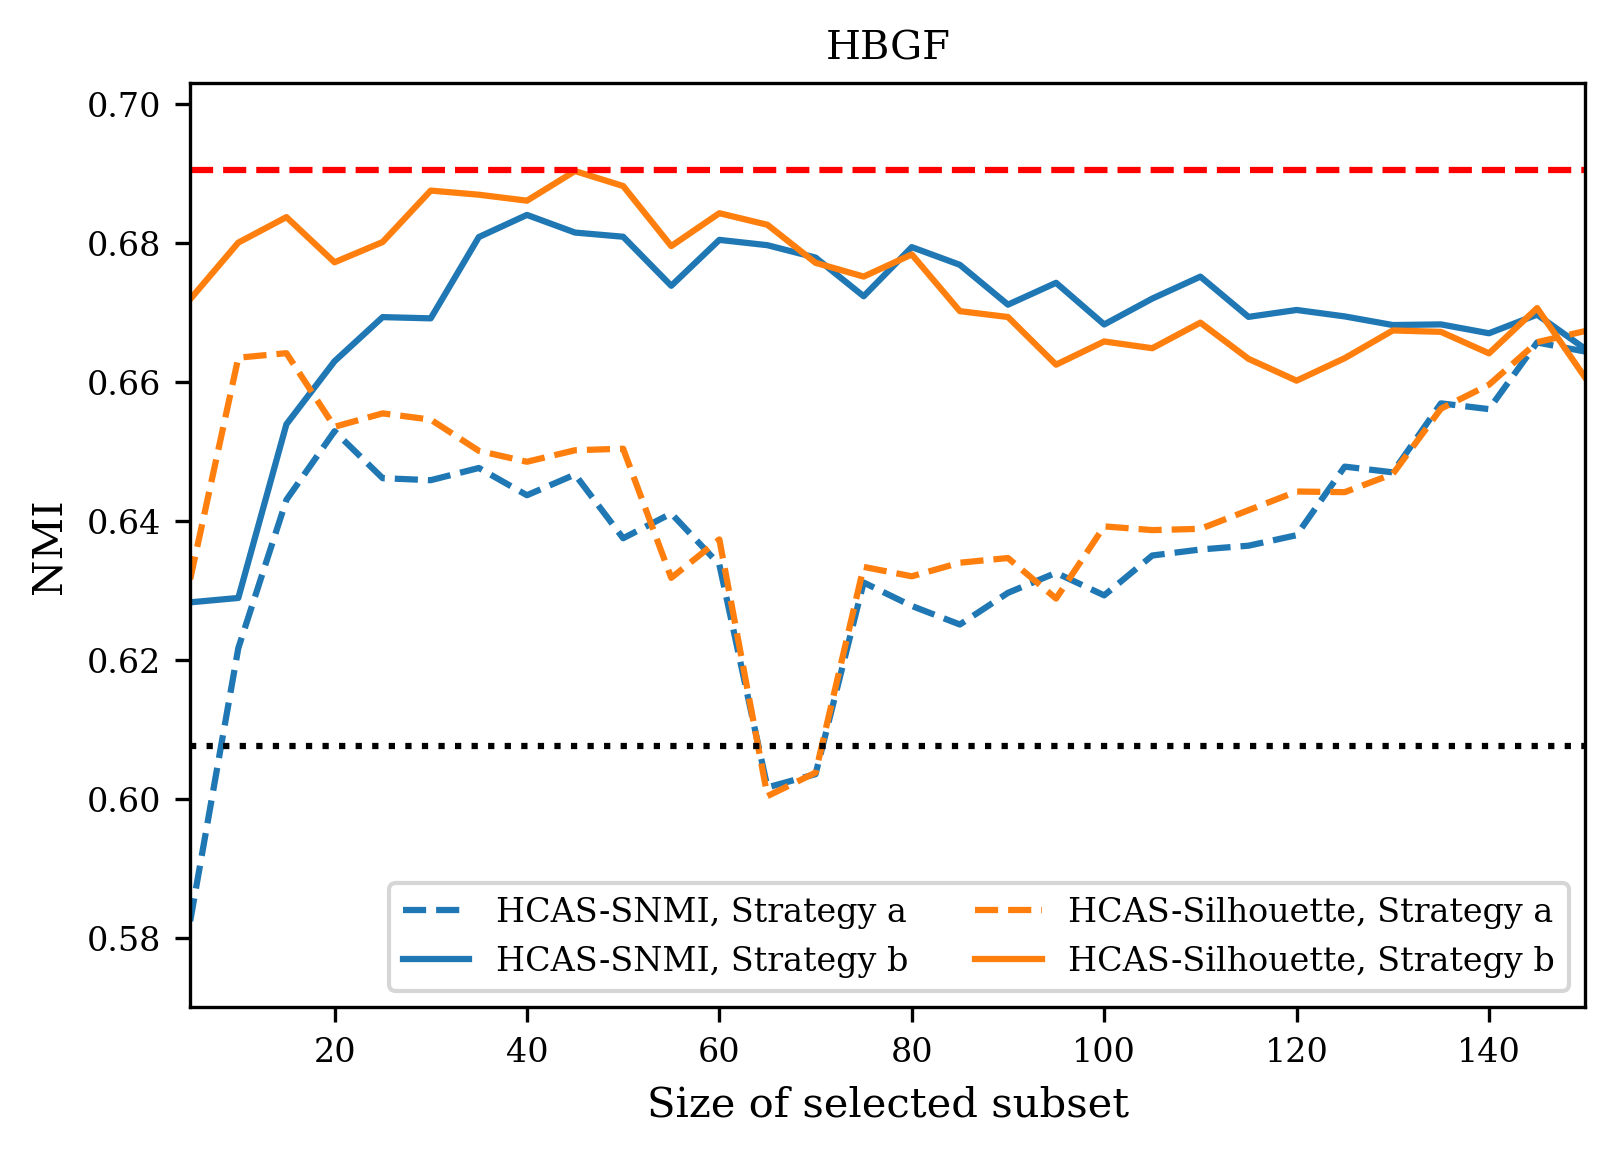

In [259]:
print("HBGF consensus function, NMI")
num=range(5,155,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.title("HBGF")
plt.xlim(5,150,5)
plt.ylim(0.57,0.703,0.01)
plt.plot(num,df_final_average.loc["HBGF_SNMI_NMI"], label = "HCAS-SNMI, Strategy a",linestyle="--", color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Sorted_SNMI_NMI"], label = "HCAS-SNMI, Strategy b", color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Silhouette_NMI"], label = "HCAS-Silhouette, Strategy a",linestyle="--", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HBGF_Sorted_Silhouette_NMI"],label = "HCAS-Silhouette, Strategy b",  color="#ff7f0e")

plt.axhline(y=NMI_HBGF_EN, color="r", linestyle="--")
plt.axhline(y=NMI_Average, color="black", linestyle=":")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" HCAS-SQI "+Method+" using HBGF comparison NMI.png", bbox_inches="tight", dpi = 300)

HBGF consensus function, Dominant ratio


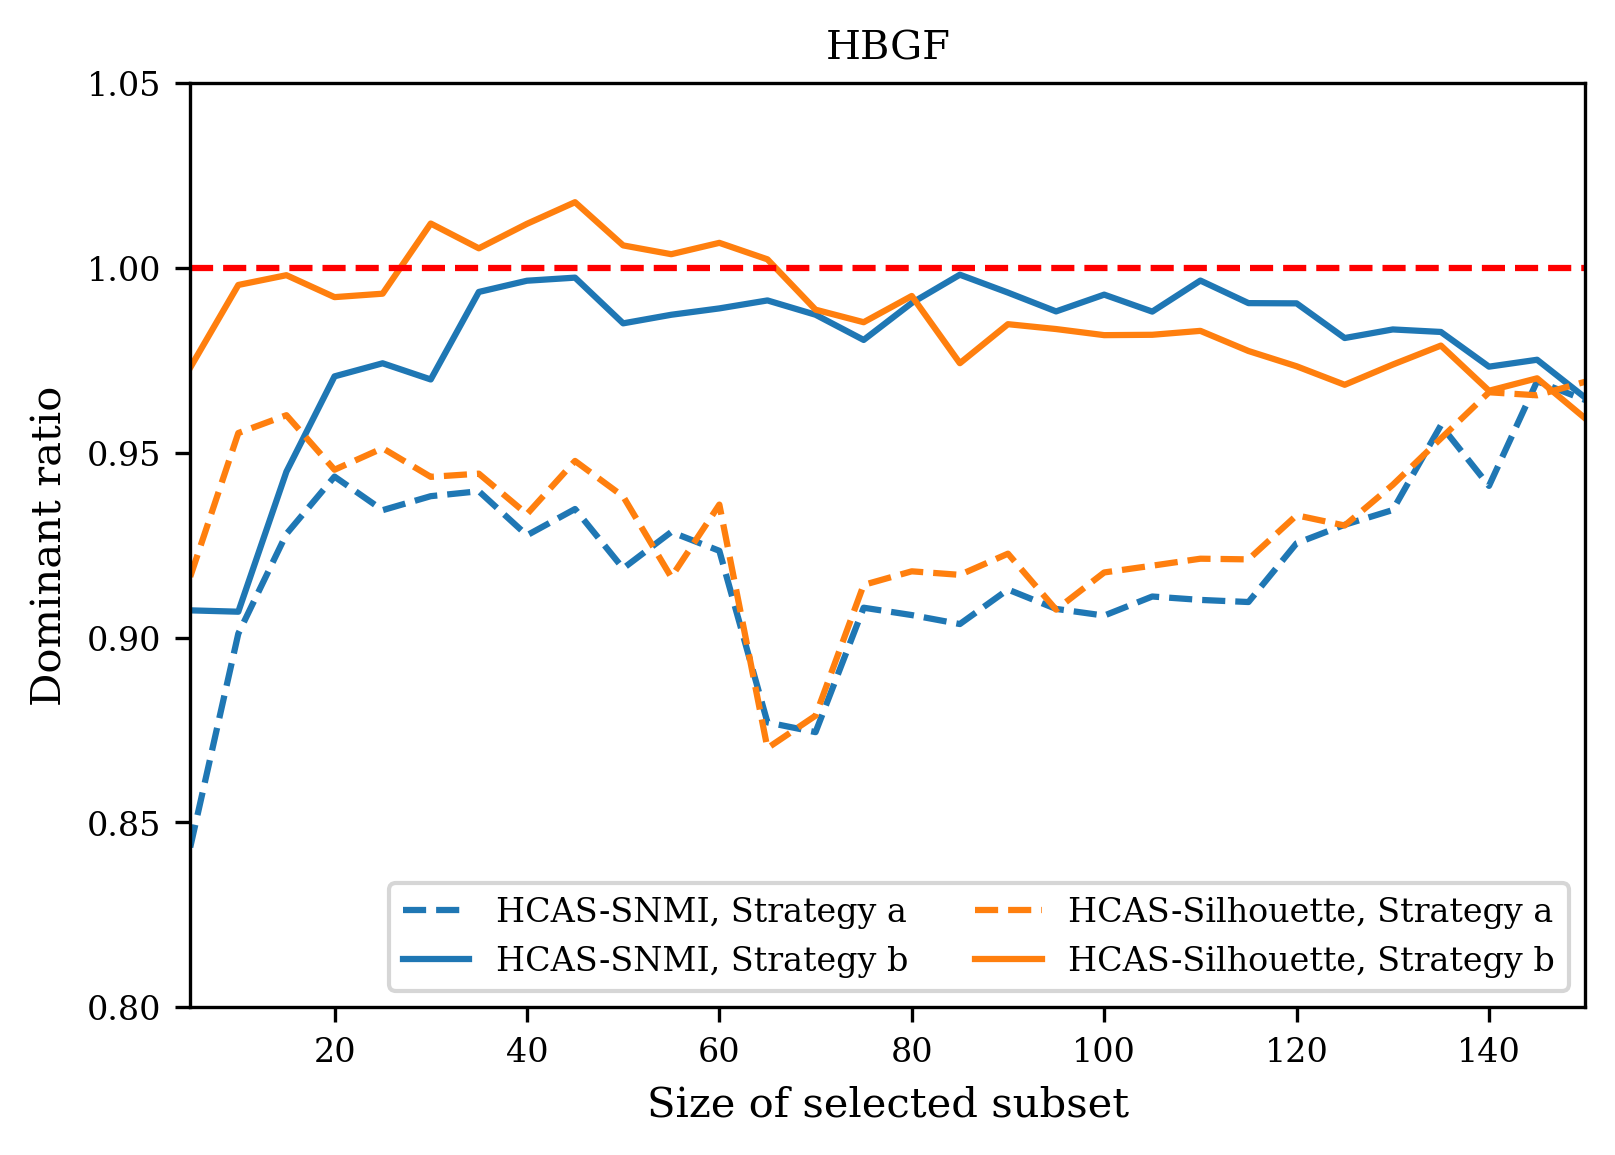

In [260]:
print("HBGF consensus function, Dominant ratio")
num=range(5,155,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.title("HBGF")
plt.xlim(5,150,5)
plt.ylim(0.8,1.05,0.1)
plt.plot(num,df_final_average.loc["HBGF_SNMI_Dominant_ratio"], label = "HCAS-SNMI, Strategy a", linestyle="--",color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Sorted_SNMI_Dominant_ratio"], label = "HCAS-SNMI, Strategy b", color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Silhouette_Dominant_ratio"], label = "HCAS-Silhouette, Strategy a",linestyle="--", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HBGF_Sorted_Silhouette_Dominant_ratio"], label = "HCAS-Silhouette, Strategy b", color="#ff7f0e")

plt.axhline(y=1.00, color="r", linestyle="--")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" HCAS-SQI "+Method+" using HBGF comparison Dominant ratio.png", bbox_inches="tight", dpi = 300)

### Compare effect of different hierarchical linkage method

In [44]:
def get_values(method):
    df = df_final_average
    print(method.upper())
    print(NMI_CSPA_EN)
    print("SNMI maximal NMI = %.3f" %df.loc["CSPA_Sorted_SNMI_NMI"].max())
    print("SNMI maximal Dominant ratio = %.2f" %df.loc["CSPA_Sorted_SNMI_Dominant_ratio"].max())
    
    print("Silhouette maximal NMI = %.3f" %df.loc["CSPA_Sorted_Silhouette_NMI"].max())
    print("Silhouette maximal Dominant ratio = %.2f" %df.loc["CSPA_Sorted_Silhouette_Dominant_ratio"].max())

In [45]:
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(5, "single")
get_values("single")
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(5, "complete")
get_values("complete")
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(5, "average")
get_values("average")
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(5, "weighted")
get_values("weighted")
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(5, "ward")
get_values("ward")

run_1
run_2
run_3
run_4
run_5
Total of  5 iterations to avearge
SINGLE
0.6592049471952801
SNMI maximal NMI = 0.693
SNMI maximal Dominant ratio = 1.06
Silhouette maximal NMI = 0.668
Silhouette maximal Dominant ratio = 1.05
run_1
run_2
run_3
run_4
run_5
Total of  5 iterations to avearge
COMPLETE
0.6592049471952801
SNMI maximal NMI = 0.700
SNMI maximal Dominant ratio = 1.08
Silhouette maximal NMI = 0.672
Silhouette maximal Dominant ratio = 1.04
run_1
run_2
run_3
run_4
run_5
Total of  5 iterations to avearge
AVERAGE
0.6592049471952801
SNMI maximal NMI = 0.695
SNMI maximal Dominant ratio = 1.07
Silhouette maximal NMI = 0.673
Silhouette maximal Dominant ratio = 1.04
run_1
run_2
run_3
run_4
run_5
Total of  5 iterations to avearge
WEIGHTED
0.6592049471952801
SNMI maximal NMI = 0.694
SNMI maximal Dominant ratio = 1.07
Silhouette maximal NMI = 0.670
Silhouette maximal Dominant ratio = 1.04
run_1
run_2
run_3
run_4
run_5
Total of  5 iterations to avearge
WARD
0.6592049471952801
SNMI maximal NMI = 

### Paired T-test

In [20]:
from scipy import stats

In [3]:
def get_T_test_data(n):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    NMI_CSPA_EN = []
    NMI_HBGF_EN = []
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        NMI_CSPA_EN.append(normalized_mutual_info_score(Y,Y_CSPA_EN)) 
        Y_HBGF_EN = result_i.loc["HBGF_EN"]
        NMI_HBGF_EN.append(normalized_mutual_info_score(Y,Y_HBGF_EN))

        run_i = pd.read_csv(output_path+filename+" HCAS-SQI comparison_"+ Method+"_run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    
    df_concat=pd.concat(runs)
    
    return df_concat, NMI_CSPA_EN, NMI_HBGF_EN

In [268]:
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"
Method = 'ward'
row_idx = ['CSPA_Sorted_SNMI_NMI','CSPA_Sorted_Silhouette_NMI','HBGF_Sorted_SNMI_NMI','HBGF_Sorted_Silhouette_NMI']
column_idx = [1,5,9,13,17,21]
df_Test_Data, NMI_CSPA, NMI_HBGF = get_T_test_data(20)

run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge


In [271]:
print(np.mean(NMI_CSPA), np.std(NMI_CSPA))
shapiro_test = stats.shapiro(NMI_CSPA)
if shapiro_test.pvalue >=0.05:
    print("YES, data is normally distributed")
else:
    print("No, data is non-normally distributed, t test is not appopriate")
print(np.mean(NMI_HBGF), np.std(NMI_HBGF))
shapiro_test = stats.shapiro(NMI_HBGF)
if shapiro_test.pvalue >=0.05:
    print("YES, data is normally distributed")
else:
    print("No, data is non-normally distributed, t test is not appopriate")

0.6607164486962144 0.011841835514762462
YES, data is normally distributed
0.6904820544427916 0.016005759647064074
YES, data is normally distributed


In [272]:
for i in range(0,2):
    print(row_idx[i])
    df_tmp_1 = df_Test_Data.loc[row_idx[i]]
    df_tmp_2 = df_tmp_1.iloc[:,column_idx]
    print(df_tmp_2.describe())
    
    for j in range(6):
        shapiro_test = stats.shapiro(df_tmp_2.iloc[:,j])
        if shapiro_test.pvalue >=0.05:
            print("YES, data is normally distributed")
        else:
            print("No, data is non-normally distributed, t test is not appopriate")
            
        t_test = stats.ttest_rel(NMI_CSPA,df_tmp_2.iloc[:,j])
        print(t_test.pvalue)
        if t_test.pvalue >= 0.05:
            print("p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant")
        else:
            print("YES!")
            print("p-value is less than 0.05, reject the null hypothesis, data is statistically significant")

CSPA_Sorted_SNMI_NMI
              10         30         50         70         90        110
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.639789   0.685421   0.690258   0.688683   0.677179   0.664843
std     0.018788   0.017028   0.012030   0.008119   0.011681   0.004164
min     0.614221   0.637117   0.659150   0.677368   0.653259   0.656597
25%     0.630302   0.677418   0.684356   0.683613   0.668513   0.662475
50%     0.636267   0.687156   0.691036   0.686287   0.680049   0.665183
75%     0.647591   0.695629   0.699751   0.692186   0.684467   0.668623
max     0.685870   0.710297   0.705148   0.709969   0.693193   0.671176
YES, data is normally distributed
0.00044161812293941186
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distributed
5.014574613819805e-07
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distribu

In [273]:
for i in range(2,4):
    print(row_idx[i])
    df_tmp_1 = df_Test_Data.loc[row_idx[i]]
    df_tmp_2 = df_tmp_1.iloc[:,column_idx]
    print(df_tmp_2.describe())
    
    for j in range(6):
        shapiro_test = stats.shapiro(df_tmp_2.iloc[:,j])
        if shapiro_test.pvalue >=0.05:
            print("YES, data is normally distributed")
        else:
            print("No, data is non-normally distributed, t test is not appopriate")
        t_test = stats.ttest_rel(NMI_HBGF,df_tmp_2.iloc[:,j])
        print(t_test.pvalue)
        if t_test.pvalue >= 0.05:
            print("p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant")
        else:
            print("YES!")
            print("p-value is less than 0.05, reject the null hypothesis, data is statistically significant")

HBGF_Sorted_SNMI_NMI
              10         30         50         70         90        110
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.628903   0.669147   0.680895   0.677898   0.671116   0.675152
std     0.038738   0.014839   0.011712   0.011224   0.016293   0.014806
min     0.555679   0.649004   0.660880   0.653030   0.642521   0.648048
25%     0.609676   0.657668   0.674256   0.670773   0.659965   0.665773
50%     0.627781   0.666886   0.679526   0.678984   0.669700   0.674687
75%     0.654168   0.674716   0.689956   0.684320   0.680101   0.688510
max     0.685727   0.697944   0.703597   0.701084   0.709535   0.696295
YES, data is normally distributed
1.5672913460506388e-06
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distributed
0.00012990687953177228
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distrib